In [149]:
import pandas as pd
import numpy as np
import os
import datetime
import sys
import bisect

sys.path.insert(0, '..')

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [150]:
import umap
import umap.plot

In [151]:
raw_df = pd.read_hdf("../data/processed/summaries_zerg.hdf", "summaries")
raw_df = raw_df[raw_df.game_duration > 280]
raw_df.head()

,game_start,game_duration,self_won,self_name,self_race_is_protoss,self_race_is_zerg,self_race_is_terran,opponent_name,opponent_race_is_protoss,opponent_race_is_zerg,...,ZergMeleeWeaponsLevel2_start,ZergMeleeWeaponsLevel2_weight,ZergMissileWeaponsLevel1_start,ZergMissileWeaponsLevel1_weight,ZergMissileWeaponsLevel2_start,ZergMissileWeaponsLevel2_weight,Zergling_start,Zergling_weight,overlordspeed_start,overlordspeed_weight
045eeb4f0df4c471d53c4f1db5eea0294279e0d69fad7af2c2624e914806a2ba_1,2020-02-02 14:59:40,318,1.0,Ragnarok,0.0,1.0,0.0,DPGCure,0.0,0.0,...,1000.0,0.0,1000.000000,0.0,1000.0,0.0,13.000000,2.234511,1000.000000,0.0
ec5459a85c6c9a22024fee37d2f1f23c4f15e0720dc14e6637fd076f528b86d4_0,2020-02-02 11:58:49,450,0.0,TSGSolar,0.0,1.0,0.0,Ragnarok,0.0,1.0,...,1000.0,0.0,1000.000000,0.0,1000.0,0.0,13.038405,3.198894,1000.000000,0.0
ec5459a85c6c9a22024fee37d2f1f23c4f15e0720dc14e6637fd076f528b86d4_1,2020-02-02 11:58:49,450,1.0,Ragnarok,0.0,1.0,0.0,TSGSolar,0.0,1.0,...,1000.0,0.0,1000.000000,0.0,1000.0,0.0,14.106736,9.517000,1000.000000,0.0
75172886d310ea051f49fa3751250afc4bab52ffae6b321413e9004424bacef9_0,2020-02-02 11:05:08,528,1.0,Ragnarok,0.0,1.0,0.0,TSGSolar,0.0,1.0,...,1000.0,0.0,18.973666,1.0,1000.0,0.0,14.730920,3.489383,19.874607,1.0
75172886d310ea051f49fa3751250afc4bab52ffae6b321413e9004424bacef9_1,2020-02-02 11:05:08,528,0.0,TSGSolar,0.0,1.0,0.0,Ragnarok,0.0,1.0,...,1000.0,0.0,17.748239,1.0,1000.0,0.0,13.038405,4.025389,20.024984,1.0


In [152]:
metadata_columns = """
self_won
game_start
game_duration
self_name self_race_is_protoss self_race_is_zerg self_race_is_terran
opponent_name
""".split()
weight_columns = [col for col in raw_df.columns if col.endswith("_weight")]

data_columns = [col for col in raw_df.columns if col not in metadata_columns]

df = raw_df[data_columns]

encoding_dim = 8

In [153]:
#df.sort_values('DarkTemplar_start').tail(10)



In [154]:
input_data = Input(shape=(len(df.columns),))

encoded = Dense(64, activation='relu')(input_data)
encoded = Dense(24, activation='relu')(input_data)
#encoded = Dense(24, activation='relu')(input_data)

encoded = Dense(encoding_dim, activation='relu',
                    activity_regularizer=regularizers.l1(10e-3))(encoded)


#decoded = Dense(24, activation='relu')(encoded)
decoded = Dense(24, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(len(df.columns), activation='linear')(decoded)

autoencoder = Model(input_data, decoded)


In [155]:
encoder = Model(input_data, encoded)

In [156]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [157]:
x_all = df.sample(frac=1.0).values
num_samples = int(0.9 * x_all.shape[0])
x_train, x_test = x_all[:num_samples, :], x_all[num_samples:, :]
print("Training on {} samples. Testing on {}.".format(
    num_samples, x_all.shape[0] - num_samples))


Training on 2800 samples. Testing on 312.


In [158]:
autoencoder.fit(x_train, x_train,
                epochs=2500,
                batch_size=512,
                shuffle=True,
                validation_data=(x_test, x_test))


Train on 2800 samples, validate on 312 samples
Epoch 1/2500
2800/2800 [==============================] - 0s 62us/step - loss: 329902.9604 - val_loss: 275240.5000
Epoch 2/2500
2800/2800 [==============================] - 0s 10us/step - loss: 182350.3686 - val_loss: 58307.9609
Epoch 3/2500
2800/2800 [==============================] - 0s 9us/step - loss: 68051.5735 - val_loss: 55970.7031
Epoch 4/2500
2800/2800 [==============================] - 0s 9us/step - loss: 64619.4204 - val_loss: 51480.3281
Epoch 5/2500
2800/2800 [==============================] - 0s 9us/step - loss: 58008.1731 - val_loss: 46408.0664
Epoch 6/2500
2800/2800 [==============================] - 0s 10us/step - loss: 52580.8833 - val_loss: 44150.6875
Epoch 7/2500
2800/2800 [==============================] - 0s 10us/step - loss: 50363.5940 - val_loss: 42770.5430
Epoch 8/2500
2800/2800 [==============================] - 0s 8us/step - loss: 47206.6542 - val_loss: 40962.1758
Epoch 9/2500
2800/2800 [==========================

Epoch 73/2500
2800/2800 [==============================] - 0s 8us/step - loss: 29278.5160 - val_loss: 27931.6055
Epoch 74/2500
2800/2800 [==============================] - 0s 7us/step - loss: 30168.2820 - val_loss: 30042.9844
Epoch 75/2500
2800/2800 [==============================] - ETA: 0s - loss: 32557.082 - 0s 8us/step - loss: 32367.2103 - val_loss: 30692.6113
Epoch 76/2500
2800/2800 [==============================] - 0s 8us/step - loss: 32579.7236 - val_loss: 29871.9414
Epoch 77/2500
2800/2800 [==============================] - 0s 8us/step - loss: 31272.0057 - val_loss: 29254.1562
Epoch 78/2500
2800/2800 [==============================] - 0s 9us/step - loss: 31082.6882 - val_loss: 29279.4375
Epoch 79/2500
2800/2800 [==============================] - 0s 8us/step - loss: 31126.0184 - val_loss: 29041.4336
Epoch 80/2500
2800/2800 [==============================] - 0s 9us/step - loss: 30458.1239 - val_loss: 28770.5332
Epoch 81/2500
2800/2800 [==============================] - 0s 8us/st

Epoch 145/2500
2800/2800 [==============================] - 0s 8us/step - loss: 27456.9311 - val_loss: 26232.9531
Epoch 146/2500
2800/2800 [==============================] - 0s 8us/step - loss: 26440.9328 - val_loss: 24830.4141
Epoch 147/2500
2800/2800 [==============================] - 0s 9us/step - loss: 26733.9981 - val_loss: 26138.0078
Epoch 148/2500
2800/2800 [==============================] - 0s 8us/step - loss: 27255.4856 - val_loss: 24854.3281
Epoch 149/2500
2800/2800 [==============================] - 0s 8us/step - loss: 26593.0845 - val_loss: 25065.5879
Epoch 150/2500
2800/2800 [==============================] - 0s 8us/step - loss: 26742.5785 - val_loss: 25767.0410
Epoch 151/2500
2800/2800 [==============================] - 0s 7us/step - loss: 26918.2640 - val_loss: 25074.5137
Epoch 152/2500
2800/2800 [==============================] - 0s 8us/step - loss: 26925.5820 - val_loss: 25615.4199
Epoch 153/2500
2800/2800 [==============================] - 0s 7us/step - loss: 27116.06

Epoch 217/2500
2800/2800 [==============================] - 0s 10us/step - loss: 20566.9267 - val_loss: 19164.9395
Epoch 218/2500
2800/2800 [==============================] - 0s 8us/step - loss: 22025.0612 - val_loss: 19756.0137
Epoch 219/2500
2800/2800 [==============================] - 0s 8us/step - loss: 20556.6826 - val_loss: 18708.7617
Epoch 220/2500
2800/2800 [==============================] - 0s 7us/step - loss: 21595.7673 - val_loss: 18370.4180
Epoch 221/2500
2800/2800 [==============================] - 0s 8us/step - loss: 20422.7583 - val_loss: 19367.1699
Epoch 222/2500
2800/2800 [==============================] - 0s 8us/step - loss: 22067.5377 - val_loss: 18907.1953
Epoch 223/2500
2800/2800 [==============================] - 0s 9us/step - loss: 21296.3026 - val_loss: 20290.5723
Epoch 224/2500
2800/2800 [==============================] - 0s 8us/step - loss: 20804.1862 - val_loss: 19210.0781
Epoch 225/2500
2800/2800 [==============================] - 0s 7us/step - loss: 20308.1

Epoch 289/2500
2800/2800 [==============================] - 0s 7us/step - loss: 14757.9726 - val_loss: 13340.2461
Epoch 290/2500
2800/2800 [==============================] - 0s 7us/step - loss: 15317.5305 - val_loss: 15247.1953
Epoch 291/2500
2800/2800 [==============================] - 0s 7us/step - loss: 17145.1240 - val_loss: 16941.0645
Epoch 292/2500
2800/2800 [==============================] - 0s 8us/step - loss: 17679.0867 - val_loss: 16066.4736
Epoch 293/2500
2800/2800 [==============================] - 0s 8us/step - loss: 17655.6762 - val_loss: 14979.0049
Epoch 294/2500
2800/2800 [==============================] - 0s 8us/step - loss: 16673.1748 - val_loss: 15517.1963
Epoch 295/2500
2800/2800 [==============================] - 0s 7us/step - loss: 16469.7794 - val_loss: 14564.7324
Epoch 296/2500
2800/2800 [==============================] - 0s 8us/step - loss: 16569.8953 - val_loss: 15413.9580
Epoch 297/2500
2800/2800 [==============================] - 0s 9us/step - loss: 16468.16

Epoch 361/2500
2800/2800 [==============================] - 0s 9us/step - loss: 15725.0297 - val_loss: 12725.2568
Epoch 362/2500
2800/2800 [==============================] - 0s 8us/step - loss: 14959.4944 - val_loss: 12301.4492
Epoch 363/2500
2800/2800 [==============================] - 0s 8us/step - loss: 13959.0672 - val_loss: 11969.9971
Epoch 364/2500
2800/2800 [==============================] - 0s 8us/step - loss: 13778.6890 - val_loss: 12959.1367
Epoch 365/2500
2800/2800 [==============================] - 0s 8us/step - loss: 15082.4306 - val_loss: 12952.3369
Epoch 366/2500
2800/2800 [==============================] - 0s 8us/step - loss: 14656.5218 - val_loss: 13747.9512
Epoch 367/2500
2800/2800 [==============================] - 0s 8us/step - loss: 15350.9353 - val_loss: 13168.2100
Epoch 368/2500
2800/2800 [==============================] - 0s 7us/step - loss: 14807.5918 - val_loss: 13207.6924
Epoch 369/2500
2800/2800 [==============================] - 0s 8us/step - loss: 15204.99

Epoch 433/2500
2800/2800 [==============================] - 0s 7us/step - loss: 13567.2460 - val_loss: 12285.5254
Epoch 434/2500
2800/2800 [==============================] - 0s 8us/step - loss: 13938.1088 - val_loss: 12055.0117
Epoch 435/2500
2800/2800 [==============================] - 0s 8us/step - loss: 13787.2090 - val_loss: 12689.6611
Epoch 436/2500
2800/2800 [==============================] - 0s 9us/step - loss: 14451.7566 - val_loss: 11986.1201
Epoch 437/2500
2800/2800 [==============================] - ETA: 0s - loss: 13562.858 - 0s 7us/step - loss: 13104.7590 - val_loss: 10967.6006
Epoch 438/2500
2800/2800 [==============================] - 0s 8us/step - loss: 12315.5257 - val_loss: 11506.5664
Epoch 439/2500
2800/2800 [==============================] - 0s 8us/step - loss: 13780.7980 - val_loss: 11327.3799
Epoch 440/2500
2800/2800 [==============================] - 0s 7us/step - loss: 12981.3989 - val_loss: 11514.3545
Epoch 441/2500
2800/2800 [==============================] - 

2800/2800 [==============================] - 0s 8us/step - loss: 13966.4614 - val_loss: 11131.9473
Epoch 505/2500
2800/2800 [==============================] - 0s 8us/step - loss: 11689.3973 - val_loss: 10242.2148
Epoch 506/2500
2800/2800 [==============================] - 0s 9us/step - loss: 12130.4629 - val_loss: 10516.2422
Epoch 507/2500
2800/2800 [==============================] - 0s 9us/step - loss: 11735.5161 - val_loss: 10457.9600
Epoch 508/2500
2800/2800 [==============================] - 0s 8us/step - loss: 12017.2450 - val_loss: 10778.3555
Epoch 509/2500
2800/2800 [==============================] - 0s 9us/step - loss: 11982.9889 - val_loss: 11280.8037
Epoch 510/2500
2800/2800 [==============================] - 0s 9us/step - loss: 12790.4457 - val_loss: 11636.0459
Epoch 511/2500
2800/2800 [==============================] - 0s 9us/step - loss: 13190.3218 - val_loss: 11889.7100
Epoch 512/2500
2800/2800 [==============================] - 0s 8us/step - loss: 12958.8926 - val_loss: 

Epoch 576/2500
2800/2800 [==============================] - 0s 8us/step - loss: 12277.9826 - val_loss: 10993.4092
Epoch 577/2500
2800/2800 [==============================] - 0s 8us/step - loss: 12679.6845 - val_loss: 11152.9004
Epoch 578/2500
2800/2800 [==============================] - 0s 8us/step - loss: 12393.1279 - val_loss: 10894.0898
Epoch 579/2500
2800/2800 [==============================] - 0s 7us/step - loss: 12627.9835 - val_loss: 11172.8213
Epoch 580/2500
2800/2800 [==============================] - 0s 8us/step - loss: 12867.6542 - val_loss: 10635.4912
Epoch 581/2500
2800/2800 [==============================] - 0s 8us/step - loss: 11752.1696 - val_loss: 11105.8945
Epoch 582/2500
2800/2800 [==============================] - 0s 7us/step - loss: 12485.6804 - val_loss: 10926.2803
Epoch 583/2500
2800/2800 [==============================] - 0s 8us/step - loss: 12534.0198 - val_loss: 10723.2275
Epoch 584/2500
2800/2800 [==============================] - 0s 8us/step - loss: 12196.79

Epoch 648/2500
2800/2800 [==============================] - 0s 8us/step - loss: 12480.2402 - val_loss: 9731.1777
Epoch 649/2500
2800/2800 [==============================] - 0s 7us/step - loss: 11238.6370 - val_loss: 10831.3242
Epoch 650/2500
2800/2800 [==============================] - 0s 8us/step - loss: 11992.5327 - val_loss: 10867.5947
Epoch 651/2500
2800/2800 [==============================] - 0s 8us/step - loss: 12344.5989 - val_loss: 10554.5684
Epoch 652/2500
2800/2800 [==============================] - 0s 7us/step - loss: 11602.3962 - val_loss: 10527.6299
Epoch 653/2500
2800/2800 [==============================] - 0s 8us/step - loss: 11630.9213 - val_loss: 10531.4736
Epoch 654/2500
2800/2800 [==============================] - 0s 9us/step - loss: 12184.9286 - val_loss: 10879.7178
Epoch 655/2500
2800/2800 [==============================] - 0s 8us/step - loss: 12146.1004 - val_loss: 11083.4326
Epoch 656/2500
2800/2800 [==============================] - 0s 8us/step - loss: 12629.841

2800/2800 [==============================] - 0s 8us/step - loss: 11642.9341 - val_loss: 10231.6113
Epoch 721/2500
2800/2800 [==============================] - 0s 9us/step - loss: 11665.8349 - val_loss: 10194.5586
Epoch 722/2500
2800/2800 [==============================] - 0s 10us/step - loss: 11561.2753 - val_loss: 9859.5303
Epoch 723/2500
2800/2800 [==============================] - 0s 8us/step - loss: 11334.4856 - val_loss: 10996.3389
Epoch 724/2500
2800/2800 [==============================] - 0s 9us/step - loss: 11692.6371 - val_loss: 9998.9863
Epoch 725/2500
2800/2800 [==============================] - 0s 8us/step - loss: 11227.4670 - val_loss: 10519.9824
Epoch 726/2500
2800/2800 [==============================] - 0s 8us/step - loss: 11847.4879 - val_loss: 10336.3369
Epoch 727/2500
2800/2800 [==============================] - 0s 8us/step - loss: 11491.2189 - val_loss: 9991.8389
Epoch 728/2500
2800/2800 [==============================] - 0s 9us/step - loss: 11117.0412 - val_loss: 99

2800/2800 [==============================] - 0s 11us/step - loss: 11186.5298 - val_loss: 10166.7881
Epoch 793/2500
2800/2800 [==============================] - 0s 10us/step - loss: 11116.0762 - val_loss: 10301.7100
Epoch 794/2500
2800/2800 [==============================] - 0s 9us/step - loss: 11142.6131 - val_loss: 8767.6504
Epoch 795/2500
2800/2800 [==============================] - 0s 9us/step - loss: 10015.5222 - val_loss: 9398.4150
Epoch 796/2500
2800/2800 [==============================] - 0s 9us/step - loss: 10789.5970 - val_loss: 9530.0771
Epoch 797/2500
2800/2800 [==============================] - 0s 8us/step - loss: 10935.2982 - val_loss: 9527.7646
Epoch 798/2500
2800/2800 [==============================] - 0s 9us/step - loss: 10716.6294 - val_loss: 9793.5967
Epoch 799/2500
2800/2800 [==============================] - 0s 8us/step - loss: 10927.0549 - val_loss: 9956.6826
Epoch 800/2500
2800/2800 [==============================] - 0s 8us/step - loss: 11170.1588 - val_loss: 1002

2800/2800 [==============================] - 0s 8us/step - loss: 10383.9561 - val_loss: 9295.7285
Epoch 865/2500
2800/2800 [==============================] - 0s 8us/step - loss: 10543.5693 - val_loss: 9127.9785
Epoch 866/2500
2800/2800 [==============================] - 0s 9us/step - loss: 10024.4239 - val_loss: 9254.0137
Epoch 867/2500
2800/2800 [==============================] - 0s 9us/step - loss: 10420.1778 - val_loss: 9457.1289
Epoch 868/2500
2800/2800 [==============================] - 0s 9us/step - loss: 10194.5795 - val_loss: 9299.3662
Epoch 869/2500
2800/2800 [==============================] - 0s 7us/step - loss: 10287.2799 - val_loss: 9070.5234
Epoch 870/2500
2800/2800 [==============================] - 0s 7us/step - loss: 10249.5946 - val_loss: 9357.4668
Epoch 871/2500
2800/2800 [==============================] - 0s 7us/step - loss: 10587.7120 - val_loss: 9508.3926
Epoch 872/2500
2800/2800 [==============================] - 0s 9us/step - loss: 10666.9293 - val_loss: 9452.003

2800/2800 [==============================] - 0s 8us/step - loss: 10417.9212 - val_loss: 8615.3135
Epoch 937/2500
2800/2800 [==============================] - 0s 8us/step - loss: 9610.7542 - val_loss: 9074.3545
Epoch 938/2500
2800/2800 [==============================] - 0s 7us/step - loss: 10420.9979 - val_loss: 8947.9307
Epoch 939/2500
2800/2800 [==============================] - 0s 8us/step - loss: 9829.2206 - val_loss: 8762.6680
Epoch 940/2500
2800/2800 [==============================] - 0s 8us/step - loss: 9757.7729 - val_loss: 8855.7266
Epoch 941/2500
2800/2800 [==============================] - 0s 7us/step - loss: 9887.6278 - val_loss: 8915.4346
Epoch 942/2500
2800/2800 [==============================] - 0s 8us/step - loss: 9914.3190 - val_loss: 8741.6582
Epoch 943/2500
2800/2800 [==============================] - 0s 7us/step - loss: 9747.3099 - val_loss: 8372.6289
Epoch 944/2500
2800/2800 [==============================] - 0s 9us/step - loss: 9517.9202 - val_loss: 9490.5342
Epoch

2800/2800 [==============================] - 0s 9us/step - loss: 10479.5403 - val_loss: 8759.9004
Epoch 1009/2500
2800/2800 [==============================] - 0s 10us/step - loss: 9882.9946 - val_loss: 8970.1709
Epoch 1010/2500
2800/2800 [==============================] - 0s 9us/step - loss: 10342.7541 - val_loss: 9503.2422
Epoch 1011/2500
2800/2800 [==============================] - 0s 9us/step - loss: 10314.8388 - val_loss: 8533.0840
Epoch 1012/2500
2800/2800 [==============================] - 0s 8us/step - loss: 9536.6976 - val_loss: 9249.1680
Epoch 1013/2500
2800/2800 [==============================] - 0s 8us/step - loss: 9949.9266 - val_loss: 8803.3418
Epoch 1014/2500
2800/2800 [==============================] - 0s 7us/step - loss: 9656.3024 - val_loss: 8996.2686
Epoch 1015/2500
2800/2800 [==============================] - 0s 9us/step - loss: 9905.4602 - val_loss: 8560.0537
Epoch 1016/2500
2800/2800 [==============================] - 0s 9us/step - loss: 9514.7032 - val_loss: 8751.

2800/2800 [==============================] - 0s 8us/step - loss: 9597.1009 - val_loss: 9209.2080
Epoch 1081/2500
2800/2800 [==============================] - 0s 8us/step - loss: 10494.0555 - val_loss: 9660.1221
Epoch 1082/2500
2800/2800 [==============================] - 0s 7us/step - loss: 9617.3315 - val_loss: 8925.8535
Epoch 1083/2500
2800/2800 [==============================] - 0s 8us/step - loss: 10131.8334 - val_loss: 9043.9658
Epoch 1084/2500
2800/2800 [==============================] - 0s 7us/step - loss: 9800.8867 - val_loss: 8459.1064
Epoch 1085/2500
2800/2800 [==============================] - 0s 8us/step - loss: 9168.0794 - val_loss: 8322.8135
Epoch 1086/2500
2800/2800 [==============================] - 0s 8us/step - loss: 9110.5355 - val_loss: 8216.4434
Epoch 1087/2500
2800/2800 [==============================] - 0s 7us/step - loss: 9531.1854 - val_loss: 9166.3086
Epoch 1088/2500
2800/2800 [==============================] - 0s 7us/step - loss: 9969.3242 - val_loss: 8567.99

2800/2800 [==============================] - 0s 9us/step - loss: 9759.9734 - val_loss: 7766.8291
Epoch 1153/2500
2800/2800 [==============================] - 0s 9us/step - loss: 8494.4539 - val_loss: 7863.3159
Epoch 1154/2500
2800/2800 [==============================] - 0s 9us/step - loss: 9033.4547 - val_loss: 8486.4932
Epoch 1155/2500
2800/2800 [==============================] - 0s 8us/step - loss: 9300.9045 - val_loss: 8530.6855
Epoch 1156/2500
2800/2800 [==============================] - 0s 10us/step - loss: 9244.8799 - val_loss: 8380.2275
Epoch 1157/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8637.8533 - val_loss: 7983.0996
Epoch 1158/2500
2800/2800 [==============================] - 0s 10us/step - loss: 9083.4338 - val_loss: 8362.4434
Epoch 1159/2500
2800/2800 [==============================] - 0s 9us/step - loss: 9227.1917 - val_loss: 8232.3994
Epoch 1160/2500
2800/2800 [==============================] - 0s 9us/step - loss: 8903.5584 - val_loss: 8348.18

2800/2800 [==============================] - 0s 9us/step - loss: 9194.2978 - val_loss: 8701.9141
Epoch 1225/2500
2800/2800 [==============================] - 0s 9us/step - loss: 9665.6835 - val_loss: 7236.0347
Epoch 1226/2500
2800/2800 [==============================] - 0s 9us/step - loss: 7931.4282 - val_loss: 7635.3232
Epoch 1227/2500
2800/2800 [==============================] - 0s 9us/step - loss: 8829.4225 - val_loss: 7866.5371
Epoch 1228/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8894.7650 - val_loss: 7412.8989
Epoch 1229/2500
2800/2800 [==============================] - 0s 9us/step - loss: 8356.2589 - val_loss: 7709.5435
Epoch 1230/2500
2800/2800 [==============================] - 0s 9us/step - loss: 8652.8414 - val_loss: 8184.9492
Epoch 1231/2500
2800/2800 [==============================] - 0s 9us/step - loss: 9195.8821 - val_loss: 7725.4219
Epoch 1232/2500
2800/2800 [==============================] - 0s 10us/step - loss: 8630.8027 - val_loss: 8024.268

2800/2800 [==============================] - 0s 8us/step - loss: 8743.7472 - val_loss: 9093.9150
Epoch 1297/2500
2800/2800 [==============================] - 0s 9us/step - loss: 9462.8743 - val_loss: 7887.3179
Epoch 1298/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8869.6072 - val_loss: 8180.9268
Epoch 1299/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8820.1525 - val_loss: 7608.3384
Epoch 1300/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8240.4609 - val_loss: 7444.5547
Epoch 1301/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8403.7895 - val_loss: 7736.4653
Epoch 1302/2500
2800/2800 [==============================] - 0s 9us/step - loss: 8783.7533 - val_loss: 7667.4219
Epoch 1303/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8168.4285 - val_loss: 7313.5366
Epoch 1304/2500
2800/2800 [==============================] - 0s 7us/step - loss: 8629.2345 - val_loss: 7539.7827

2800/2800 [==============================] - 0s 9us/step - loss: 8125.7622 - val_loss: 7270.1475
Epoch 1369/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8203.7005 - val_loss: 7222.4434
Epoch 1370/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8234.1798 - val_loss: 7764.8120
Epoch 1371/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8563.9115 - val_loss: 7667.2153
Epoch 1372/2500
2800/2800 [==============================] - 0s 9us/step - loss: 8609.0975 - val_loss: 7039.6094
Epoch 1373/2500
2800/2800 [==============================] - 0s 9us/step - loss: 8155.7648 - val_loss: 8447.8643
Epoch 1374/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8698.1570 - val_loss: 6880.1885
Epoch 1375/2500
2800/2800 [==============================] - 0s 7us/step - loss: 7641.8215 - val_loss: 6596.7666
Epoch 1376/2500
2800/2800 [==============================] - 0s 8us/step - loss: 7299.1603 - val_loss: 6547.9312

2800/2800 [==============================] - 0s 7us/step - loss: 8373.5983 - val_loss: 7413.2148
Epoch 1441/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8072.8118 - val_loss: 7171.1758
Epoch 1442/2500
2800/2800 [==============================] - 0s 7us/step - loss: 8185.1060 - val_loss: 7442.5898
Epoch 1443/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8256.8149 - val_loss: 7477.0542
Epoch 1444/2500
2800/2800 [==============================] - 0s 9us/step - loss: 8303.2966 - val_loss: 6984.2432
Epoch 1445/2500
2800/2800 [==============================] - 0s 8us/step - loss: 7768.7345 - val_loss: 6947.1182
Epoch 1446/2500
2800/2800 [==============================] - 0s 9us/step - loss: 8232.3186 - val_loss: 7952.4375
Epoch 1447/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8458.3898 - val_loss: 6960.6675
Epoch 1448/2500
2800/2800 [==============================] - 0s 8us/step - loss: 7401.2244 - val_loss: 6848.8257

2800/2800 [==============================] - 0s 9us/step - loss: 8115.9907 - val_loss: 7061.0684
Epoch 1513/2500
2800/2800 [==============================] - 0s 8us/step - loss: 7975.0752 - val_loss: 6807.8809
Epoch 1514/2500
2800/2800 [==============================] - 0s 9us/step - loss: 7842.8812 - val_loss: 7071.5439
Epoch 1515/2500
2800/2800 [==============================] - 0s 9us/step - loss: 8255.8522 - val_loss: 7140.6016
Epoch 1516/2500
2800/2800 [==============================] - 0s 10us/step - loss: 7839.5969 - val_loss: 6918.5518
Epoch 1517/2500
2800/2800 [==============================] - 0s 7us/step - loss: 7533.8903 - val_loss: 6730.3984
Epoch 1518/2500
2800/2800 [==============================] - 0s 10us/step - loss: 7663.4861 - val_loss: 6704.6328
Epoch 1519/2500
2800/2800 [==============================] - 0s 10us/step - loss: 8066.1495 - val_loss: 7673.1943
Epoch 1520/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8018.3215 - val_loss: 6463.6

2800/2800 [==============================] - 0s 9us/step - loss: 8028.4215 - val_loss: 7559.9644
Epoch 1585/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8302.2679 - val_loss: 7278.7471
Epoch 1586/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8102.1370 - val_loss: 7281.9219
Epoch 1587/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8138.5097 - val_loss: 6968.4395
Epoch 1588/2500
2800/2800 [==============================] - 0s 7us/step - loss: 7770.0105 - val_loss: 6862.1284
Epoch 1589/2500
2800/2800 [==============================] - 0s 7us/step - loss: 7918.1406 - val_loss: 7499.1719
Epoch 1590/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8239.9970 - val_loss: 6616.7817
Epoch 1591/2500
2800/2800 [==============================] - 0s 8us/step - loss: 7262.6654 - val_loss: 6211.4849
Epoch 1592/2500
2800/2800 [==============================] - 0s 8us/step - loss: 7129.8329 - val_loss: 6833.2031

2800/2800 [==============================] - 0s 9us/step - loss: 7082.2470 - val_loss: 6252.5483
Epoch 1657/2500
2800/2800 [==============================] - 0s 7us/step - loss: 6903.8180 - val_loss: 6645.5283
Epoch 1658/2500
2800/2800 [==============================] - 0s 8us/step - loss: 7475.6684 - val_loss: 7277.4243
Epoch 1659/2500
2800/2800 [==============================] - 0s 9us/step - loss: 7907.4151 - val_loss: 6795.2812
Epoch 1660/2500
2800/2800 [==============================] - 0s 8us/step - loss: 7725.5941 - val_loss: 7375.5537
Epoch 1661/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8062.3639 - val_loss: 7531.3369
Epoch 1662/2500
2800/2800 [==============================] - 0s 8us/step - loss: 8324.7001 - val_loss: 7556.5884
Epoch 1663/2500
2800/2800 [==============================] - 0s 8us/step - loss: 7653.6915 - val_loss: 6751.6514
Epoch 1664/2500
2800/2800 [==============================] - 0s 9us/step - loss: 7367.5725 - val_loss: 7094.7930

2800/2800 [==============================] - 0s 8us/step - loss: 6231.7744 - val_loss: 5959.5786
Epoch 1729/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6707.7167 - val_loss: 6237.3374
Epoch 1730/2500
2800/2800 [==============================] - 0s 9us/step - loss: 7072.0433 - val_loss: 6910.5376
Epoch 1731/2500
2800/2800 [==============================] - 0s 9us/step - loss: 7374.9471 - val_loss: 7018.4404
Epoch 1732/2500
2800/2800 [==============================] - 0s 9us/step - loss: 7642.3951 - val_loss: 6782.8428
Epoch 1733/2500
2800/2800 [==============================] - 0s 8us/step - loss: 7072.2184 - val_loss: 5881.2393
Epoch 1734/2500
2800/2800 [==============================] - 0s 9us/step - loss: 6920.5857 - val_loss: 6513.1035
Epoch 1735/2500
2800/2800 [==============================] - 0s 9us/step - loss: 7212.3990 - val_loss: 7114.2070
Epoch 1736/2500
2800/2800 [==============================] - 0s 9us/step - loss: 7969.8539 - val_loss: 6967.8799

2800/2800 [==============================] - 0s 9us/step - loss: 6463.9702 - val_loss: 5717.9248
Epoch 1801/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6122.5223 - val_loss: 5658.7256
Epoch 1802/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6385.4768 - val_loss: 5819.3198
Epoch 1803/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6846.6515 - val_loss: 6415.4873
Epoch 1804/2500
2800/2800 [==============================] - 0s 8us/step - loss: 7234.7173 - val_loss: 6373.6851
Epoch 1805/2500
2800/2800 [==============================] - 0s 8us/step - loss: 7217.8966 - val_loss: 6146.9028
Epoch 1806/2500
2800/2800 [==============================] - 0s 9us/step - loss: 6662.0735 - val_loss: 5638.5400
Epoch 1807/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6267.6803 - val_loss: 5509.3418
Epoch 1808/2500
2800/2800 [==============================] - 0s 7us/step - loss: 6771.6636 - val_loss: 6708.8516

2800/2800 [==============================] - 0s 8us/step - loss: 6731.6881 - val_loss: 5990.6577
Epoch 1873/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6716.2387 - val_loss: 5730.3052
Epoch 1874/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6374.7595 - val_loss: 5870.1470
Epoch 1875/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6446.0333 - val_loss: 5670.1826
Epoch 1876/2500
2800/2800 [==============================] - 0s 9us/step - loss: 5919.7597 - val_loss: 5057.5806
Epoch 1877/2500
2800/2800 [==============================] - 0s 8us/step - loss: 5859.4913 - val_loss: 5413.1816
Epoch 1878/2500
2800/2800 [==============================] - 0s 7us/step - loss: 6164.2572 - val_loss: 5577.4180
Epoch 1879/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6519.5077 - val_loss: 6642.8423
Epoch 1880/2500
2800/2800 [==============================] - 0s 7us/step - loss: 6991.7131 - val_loss: 6345.6670

2800/2800 [==============================] - 0s 7us/step - loss: 5929.9463 - val_loss: 5560.6636
Epoch 1945/2500
2800/2800 [==============================] - 0s 7us/step - loss: 6445.5910 - val_loss: 5559.3882
Epoch 1946/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6142.8865 - val_loss: 5507.1973
Epoch 1947/2500
2800/2800 [==============================] - 0s 7us/step - loss: 6600.1492 - val_loss: 6465.7827
Epoch 1948/2500
2800/2800 [==============================] - 0s 7us/step - loss: 7060.2527 - val_loss: 5891.8223
Epoch 1949/2500
2800/2800 [==============================] - 0s 7us/step - loss: 6659.0035 - val_loss: 5542.7705
Epoch 1950/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6245.3763 - val_loss: 5591.8110
Epoch 1951/2500
2800/2800 [==============================] - 0s 9us/step - loss: 6386.6479 - val_loss: 5748.3765
Epoch 1952/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6861.7190 - val_loss: 6525.2715

2800/2800 [==============================] - 0s 9us/step - loss: 5430.0130 - val_loss: 5431.0938
Epoch 2017/2500
2800/2800 [==============================] - 0s 9us/step - loss: 6248.8203 - val_loss: 5866.6885
Epoch 2018/2500
2800/2800 [==============================] - 0s 9us/step - loss: 6514.8345 - val_loss: 5866.8740
Epoch 2019/2500
2800/2800 [==============================] - 0s 9us/step - loss: 6529.3190 - val_loss: 5597.9160
Epoch 2020/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6220.1160 - val_loss: 5774.8477
Epoch 2021/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6477.2664 - val_loss: 5105.2334
Epoch 2022/2500
2800/2800 [==============================] - 0s 9us/step - loss: 5766.4614 - val_loss: 5651.5176
Epoch 2023/2500
2800/2800 [==============================] - 0s 8us/step - loss: 7030.9585 - val_loss: 5728.5132
Epoch 2024/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6286.8919 - val_loss: 6515.9946

2800/2800 [==============================] - 0s 8us/step - loss: 6233.9920 - val_loss: 6161.2217
Epoch 2089/2500
2800/2800 [==============================] - 0s 10us/step - loss: 7069.9059 - val_loss: 5730.2583
Epoch 2090/2500
2800/2800 [==============================] - 0s 10us/step - loss: 6252.2036 - val_loss: 5639.4819
Epoch 2091/2500
2800/2800 [==============================] - 0s 10us/step - loss: 6495.9793 - val_loss: 5863.7715
Epoch 2092/2500
2800/2800 [==============================] - 0s 9us/step - loss: 6734.1823 - val_loss: 8332.0781
Epoch 2093/2500
2800/2800 [==============================] - 0s 11us/step - loss: 7365.1435 - val_loss: 5690.2041
Epoch 2094/2500
2800/2800 [==============================] - 0s 9us/step - loss: 6309.7504 - val_loss: 5678.0225
Epoch 2095/2500
2800/2800 [==============================] - 0s 9us/step - loss: 6354.1787 - val_loss: 5813.8755
Epoch 2096/2500
2800/2800 [==============================] - 0s 11us/step - loss: 6344.1202 - val_loss: 5191

2800/2800 [==============================] - 0s 8us/step - loss: 6011.9923 - val_loss: 5454.2676
Epoch 2161/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6261.8194 - val_loss: 5658.8350
Epoch 2162/2500
2800/2800 [==============================] - 0s 9us/step - loss: 6258.6389 - val_loss: 5706.8838
Epoch 2163/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6545.3990 - val_loss: 5699.7642
Epoch 2164/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6459.8179 - val_loss: 5904.9175
Epoch 2165/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6613.0117 - val_loss: 5194.5381
Epoch 2166/2500
2800/2800 [==============================] - 0s 9us/step - loss: 5518.3080 - val_loss: 4967.6396
Epoch 2167/2500
2800/2800 [==============================] - 0s 9us/step - loss: 5852.9552 - val_loss: 5544.5928
Epoch 2168/2500
2800/2800 [==============================] - 0s 9us/step - loss: 6121.1619 - val_loss: 5239.0273

2800/2800 [==============================] - 0s 9us/step - loss: 6335.7039 - val_loss: 6006.5513
Epoch 2233/2500
2800/2800 [==============================] - 0s 7us/step - loss: 6095.9728 - val_loss: 5999.2676
Epoch 2234/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6413.2229 - val_loss: 6026.7139
Epoch 2235/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6483.4293 - val_loss: 6025.0957
Epoch 2236/2500
2800/2800 [==============================] - 0s 7us/step - loss: 6252.2625 - val_loss: 5570.6060
Epoch 2237/2500
2800/2800 [==============================] - 0s 7us/step - loss: 6164.8301 - val_loss: 5485.2754
Epoch 2238/2500
2800/2800 [==============================] - 0s 8us/step - loss: 5853.2531 - val_loss: 5865.0093
Epoch 2239/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6008.9272 - val_loss: 5228.5078
Epoch 2240/2500
2800/2800 [==============================] - 0s 7us/step - loss: 5656.8469 - val_loss: 5332.7920

2800/2800 [==============================] - 0s 10us/step - loss: 6447.4644 - val_loss: 6520.0762
Epoch 2305/2500
2800/2800 [==============================] - 0s 9us/step - loss: 6723.5277 - val_loss: 5523.6094
Epoch 2306/2500
2800/2800 [==============================] - 0s 9us/step - loss: 5650.3060 - val_loss: 6227.6484
Epoch 2307/2500
2800/2800 [==============================] - 0s 9us/step - loss: 6709.9034 - val_loss: 6507.8096
Epoch 2308/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6793.9729 - val_loss: 6613.7256
Epoch 2309/2500
2800/2800 [==============================] - 0s 9us/step - loss: 6611.1332 - val_loss: 6103.4292
Epoch 2310/2500
2800/2800 [==============================] - 0s 9us/step - loss: 6230.3063 - val_loss: 5531.2129
Epoch 2311/2500
2800/2800 [==============================] - 0s 11us/step - loss: 5678.6671 - val_loss: 5369.2949
Epoch 2312/2500
2800/2800 [==============================] - 0s 10us/step - loss: 6316.6459 - val_loss: 6187.7

2800/2800 [==============================] - 0s 7us/step - loss: 5494.2302 - val_loss: 4952.9634
Epoch 2377/2500
2800/2800 [==============================] - 0s 9us/step - loss: 5815.1720 - val_loss: 5529.2944
Epoch 2378/2500
2800/2800 [==============================] - 0s 7us/step - loss: 6385.8818 - val_loss: 5742.4805
Epoch 2379/2500
2800/2800 [==============================] - 0s 9us/step - loss: 6432.2424 - val_loss: 5411.4771
Epoch 2380/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6104.6583 - val_loss: 5820.0386
Epoch 2381/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6288.9190 - val_loss: 5481.2202
Epoch 2382/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6192.3164 - val_loss: 5351.3491
Epoch 2383/2500
2800/2800 [==============================] - 0s 8us/step - loss: 6582.2319 - val_loss: 5856.7852
Epoch 2384/2500
2800/2800 [==============================] - 0s 9us/step - loss: 7057.9892 - val_loss: 6042.1475

2800/2800 [==============================] - 0s 9us/step - loss: 6150.6151 - val_loss: 5549.3276
Epoch 2449/2500
2800/2800 [==============================] - 0s 10us/step - loss: 6019.6652 - val_loss: 5398.9233
Epoch 2450/2500
2800/2800 [==============================] - 0s 9us/step - loss: 5774.1702 - val_loss: 4684.7090
Epoch 2451/2500
2800/2800 [==============================] - 0s 9us/step - loss: 5109.4303 - val_loss: 4399.1846
Epoch 2452/2500
2800/2800 [==============================] - 0s 8us/step - loss: 4821.0817 - val_loss: 4285.3936
Epoch 2453/2500
2800/2800 [==============================] - 0s 8us/step - loss: 5026.4510 - val_loss: 4815.6416
Epoch 2454/2500
2800/2800 [==============================] - 0s 7us/step - loss: 5100.9535 - val_loss: 4304.6885
Epoch 2455/2500
2800/2800 [==============================] - 0s 7us/step - loss: 5060.6522 - val_loss: 5097.4102
Epoch 2456/2500
2800/2800 [==============================] - 0s 9us/step - loss: 6235.9983 - val_loss: 5402.298

In [159]:
raw_df.head(1)

,game_start,game_duration,self_won,self_name,self_race_is_protoss,self_race_is_zerg,self_race_is_terran,opponent_name,opponent_race_is_protoss,opponent_race_is_zerg,...,ZergMeleeWeaponsLevel2_start,ZergMeleeWeaponsLevel2_weight,ZergMissileWeaponsLevel1_start,ZergMissileWeaponsLevel1_weight,ZergMissileWeaponsLevel2_start,ZergMissileWeaponsLevel2_weight,Zergling_start,Zergling_weight,overlordspeed_start,overlordspeed_weight
045eeb4f0df4c471d53c4f1db5eea0294279e0d69fad7af2c2624e914806a2ba_1,2020-02-02 14:59:40,318,1.0,Ragnarok,0.0,1.0,0.0,DPGCure,0.0,0.0,...,1000.0,0.0,1000.0,0.0,1000.0,0.0,13.0,2.234511,1000.0,0.0


In [160]:
autoencoder.predict(df.head(1).values)

array([[ 2.16252828e+00,  9.90969062e-01, -2.43152237e+00,
         1.01868207e+03,  1.71851265e+00,  1.03032727e+03,
         3.82119417e-02,  1.03418921e+03,  1.60953140e+00,
         3.99454069e+00,  6.24004984e+00,  1.02349487e+03,
         1.18677747e+00,  1.02938501e+03,  2.85862875e+00,
         1.03021179e+03, -1.23485303e+00,  1.03140535e+01,
         4.58014584e+00,  1.97901936e+01,  2.13736057e+00,
         1.02800928e+03, -1.44254899e+00,  1.03123206e+03,
         1.81728339e+00,  1.02803955e+03, -2.89141178e+00,
         1.03295239e+03, -1.52486432e+00,  1.04135779e+03,
        -1.00217223e+00,  1.01106329e+03, -2.21555066e+00,
         1.04033252e+03, -1.83105004e+00,  6.20929098e+00,
        -3.84535432e-01,  2.80911942e+01, -2.61219978e-01,
         4.50416527e+01,  4.82044935e+00,  3.79833832e+01,
         3.73040915e+00,  1.35852213e+01,  2.14559138e-02,
         1.04567493e+03, -1.75050616e+00,  1.07841797e+03,
        -3.08382916e+00,  1.01216345e+03, -2.83473873e+0

In [161]:
cluster_games_df = raw_df[raw_df.game_start > datetime.datetime(2020, 1, 1)]
encoded_space = encoder.predict(cluster_games_df[data_columns].values)

In [162]:
num_elements, _ = encoded_space.shape
distance_matrix = np.ndarray(shape=(num_elements, num_elements), dtype=np.float32)
single_row_item = np.ndarray(shape=encoded_space.shape, dtype=encoded_space.dtype)

for i in range(num_elements):
    single_row_item[:] = encoded_space[i, :] # broadcast single row to whole matrix

    diffs = encoded_space - single_row_item
    distance_matrix[i, :] = np.einsum("ij,ij->i", diffs, diffs)

In [170]:
distance_series = pd.Series(distance_matrix.reshape(-1))
percentiles = distance_series.quantile([
   0.05, 0.10, 0.15, 0.20, 0.25, 0.5, 0.75
])
distance_series

0              0.000000
1           9669.904297
2          45588.398438
3          47402.398438
4          49510.703125
               ...     
1368895     6098.013672
1368896    22361.433594
1368897    21286.121094
1368898    34710.695312
1368899        0.000000
Length: 1368900, dtype: float32

In [171]:
def creativity_score(row):
    base = 0.75
    too_far = len(percentiles)
    return 1000 - sum(
        base ** exponent if exponent < too_far else 0
        for exponent in (
            np.searchsorted(percentiles, x) for x in row
        )
    )

In [172]:
cluster_games_df['creativity'] = np.apply_along_axis(creativity_score, 1, distance_matrix)

<ipython-input-172-d81609fe22df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_games_df['creativity'] = np.apply_along_axis(creativity_score, 1, distance_matrix)


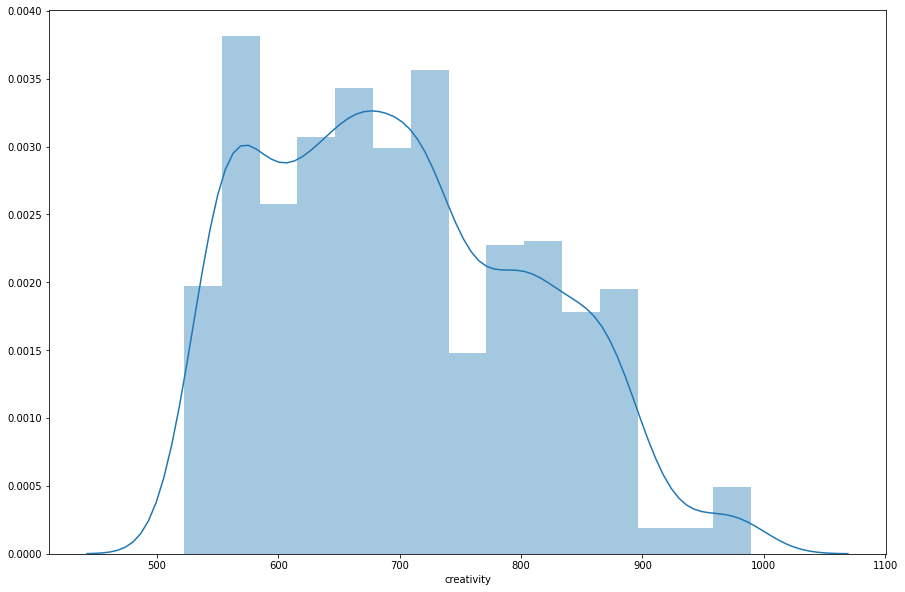

In [173]:
sns.distplot(cluster_games_df.creativity)

In [174]:
cluster_games_df.sort_values('creativity').head(20)

,game_start,game_duration,self_won,self_name,self_race_is_protoss,self_race_is_zerg,self_race_is_terran,opponent_name,opponent_race_is_protoss,opponent_race_is_zerg,...,ZergMeleeWeaponsLevel2_weight,ZergMissileWeaponsLevel1_start,ZergMissileWeaponsLevel1_weight,ZergMissileWeaponsLevel2_start,ZergMissileWeaponsLevel2_weight,Zergling_start,Zergling_weight,overlordspeed_start,overlordspeed_weight,creativity
6c1ff301d9f0e1b8695de3e758985bff20258e5a5c797596a356347b2d76cb2f_1,2020-02-13 14:30:21,374,1.0,JinairRogue,0.0,1.0,0.0,Dear,1.0,0.0,...,0.0,1000.0,0.0,1000.0,0.0,15.000000,5.340750,1000.0,0.0,522.220215
8c97d7ce31b5206104124178c19a39c7de8ddc717ffdfb91459bfd2f4029d555_1,2020-01-27 11:44:57,547,1.0,soO,0.0,1.0,0.0,DPGPartinG,1.0,0.0,...,0.0,1000.0,0.0,1000.0,0.0,9.433981,2.226005,1000.0,0.0,524.068115
0e7adaaa8d537f4fbcd86ec30e306ae640dddd679630f7c6c7c5951cba1a9ba5_0,2020-03-12 12:35:48,677,1.0,DPGDark,0.0,1.0,0.0,Zest,1.0,0.0,...,0.0,1000.0,0.0,1000.0,0.0,14.696938,9.468763,1000.0,0.0,525.217285
c70361dd3e44a62a07f7f4d97827ad9c75ae9e74a40f62fc593d1b88cb493e23_1,2020-01-12 08:11:34,592,1.0,TSGSolar,0.0,1.0,0.0,TIME,0.0,0.0,...,0.0,1000.0,0.0,1000.0,0.0,11.090537,3.598061,1000.0,0.0,535.772705
42a15fa05c4d612de539d02c0b39384d495179101e46d1f3e4542fba446527ce_0,2020-04-15 20:41:41,661,0.0,AGOElazer,0.0,1.0,0.0,HeroMarine,0.0,0.0,...,0.0,1000.0,0.0,1000.0,0.0,11.445523,2.495280,1000.0,0.0,536.128662
aa3b36ccaadb4b8a36cac5f918b5e7d8e8b0307814e833ade007b853a261b867_1,2020-04-17 17:14:29,923,0.0,LiquidTLO,0.0,1.0,0.0,soul,0.0,0.0,...,0.0,1000.0,0.0,1000.0,0.0,13.076697,8.900511,1000.0,0.0,536.588867
0e55deee04f5b91ce592b7a8d96930a3eacde18a02714cf23db7a7a072e8ad67_1,2020-01-10 14:17:12,1221,0.0,GogojOey,0.0,1.0,0.0,Nerazim,1.0,0.0,...,0.0,1000.0,0.0,1000.0,0.0,9.486833,4.497769,1000.0,0.0,536.676758
02f6a0b3b72430df3a6fb53deb7b9d9677d208988971d412de2b49a9765c1dc8_1,2020-04-14 12:57:27,906,0.0,GogojOey,0.0,1.0,0.0,Patience,1.0,0.0,...,0.0,1000.0,0.0,1000.0,0.0,9.486833,4.081756,1000.0,0.0,536.755859
e4b33af19f2e3e0105540ad637ad688ce06e1f9c7ff9a30e2c43272bb60416c7_0,2020-02-25 17:09:38,733,1.0,HateMe,0.0,1.0,0.0,Rail,1.0,0.0,...,0.0,1000.0,0.0,1000.0,0.0,13.076697,5.622547,1000.0,0.0,536.776367
aa618e8fa3bba70c1392d8eba1261f3c1c4636be738ebeddcbfe59e06e44d58a_1,2020-02-25 15:16:51,624,0.0,SortOf,0.0,1.0,0.0,Hellraiser,1.0,0.0,...,0.0,1000.0,0.0,1000.0,0.0,13.453624,5.562074,1000.0,0.0,536.776367


In [175]:
cluster_games_df.sort_values('creativity').tail(20)

,game_start,game_duration,self_won,self_name,self_race_is_protoss,self_race_is_zerg,self_race_is_terran,opponent_name,opponent_race_is_protoss,opponent_race_is_zerg,...,ZergMeleeWeaponsLevel2_weight,ZergMissileWeaponsLevel1_start,ZergMissileWeaponsLevel1_weight,ZergMissileWeaponsLevel2_start,ZergMissileWeaponsLevel2_weight,Zergling_start,Zergling_weight,overlordspeed_start,overlordspeed_weight,creativity
80e5e62a95107e0112a28a6adb8dd2e7525975614c9d027cf31c0e7690257b28_1,2020-01-17 17:19:14,372,0.0,TSGSolar,0.0,1.0,0.0,thermostaat,0.0,0.0,...,0.0,1000.000000,0.000000,1000.0,0.0,13.076697,7.235437,1000.000000,0.0,951.567383
ecd7d942daa24412a1661c2f8e3ea4038cf8b82f013075b226a4028b3d023d8e_1,2020-01-22 13:50:54,396,1.0,Impact,0.0,1.0,0.0,DPGPartinG,1.0,0.0,...,0.0,1000.000000,0.000000,1000.0,0.0,11.747340,3.432322,1000.000000,0.0,956.775635
b211b895f5c22ff976f3a8c1ebd70f992f018ec358ce407ce35d8a3b4de29a86_1,2020-02-14 19:19:17,693,1.0,AGOElazer,0.0,1.0,0.0,BlyOnFire,0.0,1.0,...,0.0,1000.000000,0.000000,1000.0,0.0,13.711309,6.531885,1000.000000,0.0,959.956787
410000e7d837815d0b41cd4f19e1184213c09941c5dfb45e3066ef6e784d7ff7_0,2020-01-11 16:54:16,675,0.0,Hukuro,0.0,1.0,0.0,Kelazhur,0.0,0.0,...,0.0,1000.000000,0.000000,1000.0,0.0,13.038405,1.994240,1000.000000,0.0,960.292969
7e24ba821ba1bb8e7904a7aa9351b075baea931027ba9d5949570d1612337ee9_0,2020-01-17 11:16:40,420,0.0,Wardí,0.0,1.0,0.0,Licemer,1.0,0.0,...,0.0,1000.000000,0.000000,1000.0,0.0,10.000000,5.159854,1000.000000,0.0,962.339111
46480854eaa6e077cf070efe6a953ca64d12b2935a8a0f8ed3e40a9af523f867_1,2020-01-05 16:07:49,385,1.0,True,0.0,1.0,0.0,MaxPax,1.0,0.0,...,0.0,1000.000000,0.000000,1000.0,0.0,11.090537,5.308428,1000.000000,0.0,963.695557
3add2751e0c553d2dedf33fab218ee8be89afa67d09ed9733304ad6fd8852b64_0,2020-02-04 18:48:11,898,1.0,Vanya,0.0,1.0,0.0,LiquidTLO,0.0,1.0,...,0.0,19.209373,1.732043,1000.0,0.0,11.000000,1.055184,1000.000000,0.0,969.633545
4ed49a46584da74a0670cbc97033d81b0f9f3c39cee70b485f913c5a947f72ef_1,2020-03-13 19:48:49,380,0.0,BlyOnFire,0.0,1.0,0.0,Reynor,0.0,1.0,...,0.0,1000.000000,0.000000,1000.0,0.0,13.076697,3.145636,1000.000000,0.0,971.780029
8868e33dd24fa9b1bf2230e4af3761132a64ebd028d3c89bee2d0621fff049e9_0,2020-04-13 12:55:20,843,0.0,BKGG,0.0,1.0,0.0,Bunny,0.0,0.0,...,0.0,1000.000000,0.000000,1000.0,0.0,13.000000,1.298089,1000.000000,0.0,971.780029
119812b928f97338cf16828e2be26a1216550c8083ccb56856e95b39365ad8e3_0,2020-03-10 20:05:34,422,1.0,Denver,0.0,1.0,0.0,Lambo,0.0,1.0,...,0.0,19.467922,1.000000,1000.0,0.0,13.076697,6.827043,1000.000000,0.0,976.723877
